# First neural network fitting for THz-TDS material parameter extraction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

## Prepare the data

In [3]:
# Prepare NN training data
df = pd.read_csv('training_data/NN_data_2025-01-24_12-39-28.csv')
print('df head:')
display(df.head())

df.describe()

df head:


,n,k,d,freq,H,phi
0,2.10168,-0.044536,0.0005,6.283185e+11,0.834011,-1.146947
1,2.10168,-0.044536,0.0005,1.117011e+12,0.804280,-2.044873
2,2.10168,-0.044536,0.0005,1.605703e+12,0.775609,-2.942798
3,2.10168,-0.044536,0.0005,2.094395e+12,0.747960,-3.840723
4,2.10168,-0.044536,0.0005,2.583087e+12,0.721296,-4.738648


,n,k,d,freq,H,phi
count,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06,1.280000e+06
mean,2.501088e+00,-4.965554e-02,5.000000e-04,1.602212e+13,3.436399e-01,-4.010366e+01
std,2.884454e-01,2.892938e-02,3.252608e-19,9.027591e+12,2.530418e-01,2.427091e+01
min,2.000000e+00,-9.999300e-02,5.000000e-04,6.283185e+11,3.985791e-03,-1.047863e+02
25%,2.250268e+00,-7.477538e-02,5.000000e-04,8.325221e+12,1.079460e-01,-5.770838e+01
50%,2.500445e+00,-4.969865e-02,5.000000e-04,1.602212e+13,3.023133e-01,-3.858035e+01
75%,2.751075e+00,-2.448265e-02,5.000000e-04,2.371902e+13,5.634518e-01,-1.974850e+01
max,3.000000e+00,-1.175980e-05,5.000000e-04,3.141593e+13,8.884799e-01,-1.032152e+00


In [4]:
# Split up data sets
X = df[['H', 'phi', 'freq']].head(int(len(df['freq'])))
Y = df[['n', 'k']].head(int(len(df['freq'])))

# Normalize frequencies to prevent weighting issues
freq_scaler = MinMaxScaler(feature_range=(0.01, 1))

X[['freq']] = freq_scaler.fit_transform(X[['freq']])

# Prepare validation datasets for plotting
N = 4   # Number of included datasets

X_val = X.head(N*64)
Y_val = Y.head(N*64)


# Check DataFrames
display(X)
display(Y)

# Check value bounds of results
print('Target bounds:')
print(f'n: min: {min(Y["n"])}, max: {max(Y["n"])}')
print(f'k: min: {min(Y["k"])}, max: {max(Y["k"])}')

,H,phi,freq
0,0.834011,-1.146947,0.010000
1,0.804280,-2.044873,0.025714
2,0.775609,-2.942798,0.041429
3,0.747960,-3.840723,0.057143
4,0.721296,-4.738648,0.072857
...,...,...,...
1279995,0.598093,-77.167907,0.937143
1279996,0.595134,-78.447961,0.952857
1279997,0.592189,-79.728015,0.968571
1279998,0.589260,-81.008068,0.984286


,n,k
0,2.10168,-0.044536
1,2.10168,-0.044536
2,2.10168,-0.044536
3,2.10168,-0.044536
4,2.10168,-0.044536
...,...,...
1279995,2.57052,-0.006085
1279996,2.57052,-0.006085
1279997,2.57052,-0.006085
1279998,2.57052,-0.006085


Target bounds:
n: min: 2.0, max: 3.0
k: min: -0.099993, max: -1.17598e-05


In [5]:
display(X_val)
display(Y_val)

,H,phi,freq
0,0.834011,-1.146947,0.010000
1,0.804280,-2.044873,0.025714
2,0.775609,-2.942798,0.041429
3,0.747960,-3.840723,0.057143
4,0.721296,-4.738648,0.072857
...,...,...,...
251,0.071614,-49.777925,0.937143
252,0.068687,-50.603767,0.952857
253,0.065878,-51.429610,0.968571
254,0.063185,-52.255452,0.984286


,n,k
0,2.10168,-0.044536
1,2.10168,-0.044536
2,2.10168,-0.044536
3,2.10168,-0.044536
4,2.10168,-0.044536
...,...,...
251,2.01324,-0.051215
252,2.01324,-0.051215
253,2.01324,-0.051215
254,2.01324,-0.051215


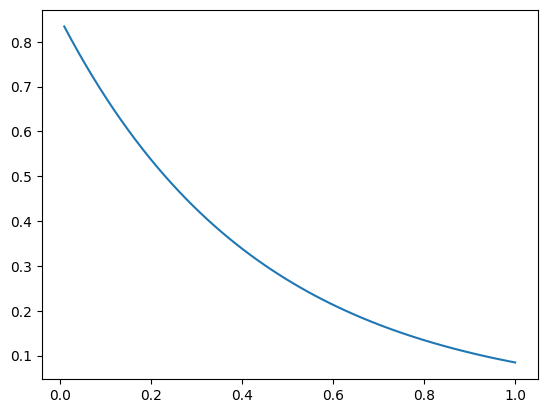

In [6]:
plt.plot(X['freq'].head(64),X['H'].head(64))

In [7]:
# Split into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Output to check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (1024000, 3)
X_test shape: (256000, 3)
Y_train shape: (1024000, 2)
Y_test shape: (256000, 2)


## First model (basic)

In [8]:
# Define the model

# TODO: test deeper network. 5x16? 

def build_model_basic(input_shape, output_shape, hidden_layers: int = 1):
    # Input layer
    inputs = Input(shape=input_shape, name="Input_Layer")
    
    # Use loops to add main hidden layers
    for i in range(hidden_layers):
        x = Dense(256, activation='tanh')(inputs) 
        #x = BatchNormalization()(x)
        #x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(output_shape, activation='linear', name="Output_Layer")(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs, name="model_basic")
    return model

In [9]:
# Model parameters
input_shape = (3,)  # Number of features in X
output_shape = 2    # Number of outputs in Y

# Build the model
model_basic = build_model_basic(input_shape, output_shape)

# Compile the model
model_basic.compile(optimizer='adam', 
                    loss='mse',  # Mean Squared Error for regression
                    metrics=['mae'])  # Mean Absolute Error as an additional metric

# Summary
model_basic.summary()

2025-02-03 11:32:57.499059: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-03 11:32:57.499098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-03 11:32:57.499108: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-03 11:32:57.499318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-03 11:32:57.499333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_basic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,538 (6.01 KB)

 Trainable params: 1,538 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model_basic.fit(X_train, Y_train,
                          validation_data=(X_test, Y_test),
                          epochs=10,
                          batch_size=128,
                          verbose=1)

# Evaluate the model
results = model_basic.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")


Epoch 1/10


2025-02-03 11:32:57.912931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0484 - mae: 0.0826 - val_loss: 0.0014 - val_mae: 0.0273
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 6.9070e-04 - val_mae: 0.0176
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 5.9776e-04 - mae: 0.0166 - val_loss: 4.9097e-04 - val_mae: 0.0162
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 4.4547e-04 - mae: 0.0143 - val_loss: 3.2607e-04 - val_mae: 0.0103
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 3.6081e-04 - mae: 0.0127 - val_loss: 3.7994e-04 - val_mae: 0.0142
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 3.0226e-04 - mae: 0.0116 - val_loss: 3.4767e-04 - val_mae: 0.0144
Epoch 7/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 2.6387e-04 - mae: 0.0109 - val_loss: 1.7881e-04 - val_mae: 0.0081
Epoch 8/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 2.3758e-04 - mae: 0.0103 - val_loss: 2.4794e-04 - val_mae

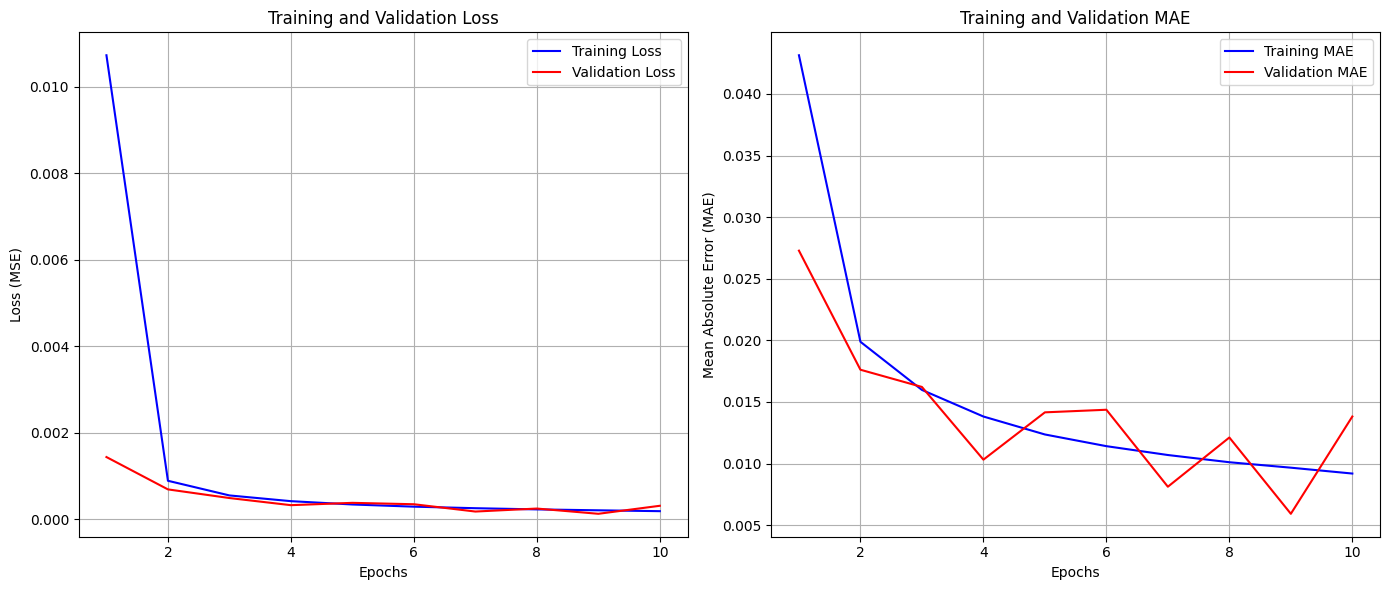

In [11]:
# Plot training and validation metrics
def plot_training_history(history):
    # Extract metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    epochs = range(1, len(loss) + 1)
    
    # Plot Loss
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [12]:
test = model_basic.predict(X_val.head(64))[:,0]

test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


array([2.0856962, 2.1002731, 2.0680783, 2.0686226, 2.0735676, 2.0748014,
       2.074049 , 2.0732188, 2.0730042, 2.0734205, 2.0742745, 2.0753777,
       2.0766   , 2.077866 , 2.079134 , 2.0803804, 2.0815902, 2.0827508,
       2.0838497, 2.084875 , 2.0858164, 2.0866637, 2.0874102, 2.088051 ,
       2.088584 , 2.0890086, 2.0893285, 2.0895472, 2.0896707, 2.0897067,
       2.089663 , 2.0895488, 2.0893724, 2.0891435, 2.088871 , 2.0885634,
       2.0882294, 2.0878763, 2.0875123, 2.0871434, 2.0867755, 2.0864148,
       2.0860653, 2.085732 , 2.0854182, 2.0851274, 2.0848615, 2.084623 ,
       2.084414 , 2.0842352, 2.0840878, 2.0839722, 2.0838885, 2.083837 ,
       2.0838175, 2.0838294, 2.0838714, 2.0839438, 2.084045 , 2.084174 ,
       2.0843294, 2.0845108, 2.0847158, 2.0849435], dtype=float32)

In [13]:
# Reshape the data: Y_val has 4 sets, each with 64 points
n_data = Y_val['n'].values.reshape(4, 64)  # Reshape to 4 sets of 64 points each
k_data = Y_val['k'].values.reshape(4, 64)

freqs = X_val['freq'].values.reshape(4, 64)
# freqs = (freqs * 1e-12) / (2 * np.pi)

# Make predictions using the model
predictions = model_basic.predict(X_val)
predictions_df = pd.DataFrame(predictions, columns=['n', 'k'])

# Reshape the data: predicted data has 4 sets, each with 64 points
n_pred = predictions_df['n'].values.reshape(4, 64)  # Reshape to 4 sets of 64 points each
k_pred = predictions_df['k'].values.reshape(4, 64)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


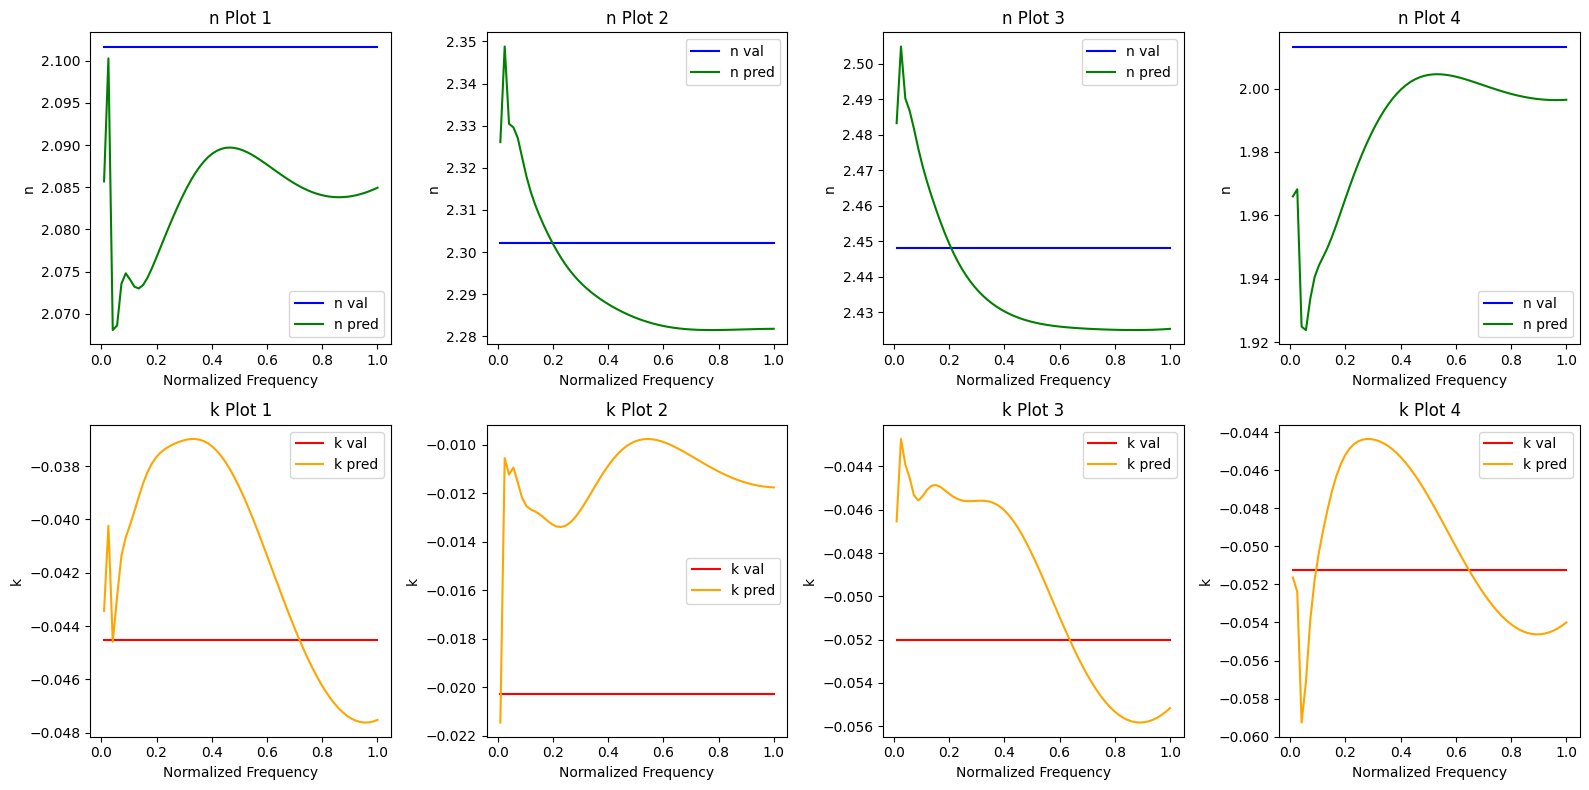

In [14]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 wide, 2 tall grid

# Plotting the n-related data (top row)
for i in range(4):  # There are 4 columns in the top row
    ax = axes[0, i]  # Access the subplot in the top row
    ax.plot(freqs[i], n_data[i], 'b-', label='n val')  # Blue for actual n
    ax.plot(freqs[i], n_pred[i], 'g-', label='n pred')  # Green for predicted n
    ax.set_title(f'n Plot {i + 1}')
    ax.set_xlabel('Normalized Frequency')
    ax.set_ylabel('n')
    ax.legend()

# Plotting the k-related data (bottom row)
for i in range(4):  # There are 4 columns in the bottom row
    ax = axes[1, i]  # Access the subplot in the bottom row
    ax.plot(freqs[i], k_data[i], 'r-', label='k val')  # Red for actual k
    ax.plot(freqs[i], k_pred[i], 'orange', label='k pred')  # Orange for predicted k
    ax.set_title(f'k Plot {i + 1}')
    ax.set_xlabel('Normalized Frequency')
    ax.set_ylabel('k')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Custom live plotting of training

In [15]:
'''
# Define the custom callback
class LivePlotCallback(Callback):
    def __init__(self):
        super(LivePlotCallback, self).__init__()
        self.epochs = []
        self.loss = []
        self.val_loss = []
        self.mae = []
        self.val_mae = []

    def on_epoch_end(self, epoch, logs=None):
        # Append metrics for each epoch
        self.epochs.append(epoch + 1)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.mae.append(logs['mae'])
        self.val_mae.append(logs['val_mae'])

        # Clear output and plot
        clear_output(wait=True)
        plt.figure(figsize=(14, 6))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.loss, 'b-', label='Training Loss')
        plt.plot(self.epochs, self.val_loss, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.mae, 'b-', label='Training MAE')
        plt.plot(self.epochs, self.val_mae, 'r-', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error (MAE)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Train the model with the custom callback
history = model_basic.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=256,
    callbacks=[LivePlotCallback()],  # Add custom callback
    verbose=1
)
'''

"\n# Define the custom callback\nclass LivePlotCallback(Callback):\n    def __init__(self):\n        super(LivePlotCallback, self).__init__()\n        self.epochs = []\n        self.loss = []\n        self.val_loss = []\n        self.mae = []\n        self.val_mae = []\n\n    def on_epoch_end(self, epoch, logs=None):\n        # Append metrics for each epoch\n        self.epochs.append(epoch + 1)\n        self.loss.append(logs['loss'])\n        self.val_loss.append(logs['val_loss'])\n        self.mae.append(logs['mae'])\n        self.val_mae.append(logs['val_mae'])\n\n        # Clear output and plot\n        clear_output(wait=True)\n        plt.figure(figsize=(14, 6))\n\n        # Plot Loss\n        plt.subplot(1, 2, 1)\n        plt.plot(self.epochs, self.loss, 'b-', label='Training Loss')\n        plt.plot(self.epochs, self.val_loss, 'r-', label='Validation Loss')\n        plt.title('Training and Validation Loss')\n        plt.xlabel('Epochs')\n        plt.ylabel('Loss (MSE)')\n       

## More complex models

### Use scaling on the same model to make mae metric less misleading

In [16]:
# Initialize scalers
scaler_n = MinMaxScaler(feature_range=(0, 1))
scaler_k = MinMaxScaler(feature_range=(0, 1))

# Normalize outputs
Y_train_scaled = Y_train.copy()
Y_test_scaled = Y_test.copy()

# Scale the columns explicitly
Y_train_scaled['n'] = scaler_n.fit_transform(Y_train[['n']])
Y_train_scaled['k'] = scaler_k.fit_transform(Y_train[['k']])
Y_test_scaled['n'] = scaler_n.transform(Y_test[['n']])
Y_test_scaled['k'] = scaler_k.transform(Y_test[['k']])

# Build the model for scaled data
model_basic_scaled = build_model_basic(input_shape, output_shape)

# Compile the model
model_basic_scaled.compile(optimizer='adam', 
                    loss='mse',  # Mean Squared Error for regression
                    metrics=['mae'])  # Mean Absolute Error as an additional metric

# Summary
model_basic_scaled.summary()

# Train the model on scaled outputs
history_scaled = model_basic_scaled.fit(
    X_train, Y_train_scaled,
    validation_data=(X_test, Y_test_scaled),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Rescale predictions for evaluation
predictions_scaled = model_basic_scaled.predict(X_test)

# Convert predictions to a DataFrame for easier handling
predictions_scaled_df = pd.DataFrame(predictions_scaled, columns=['n', 'k'])

# Rescale each output
predictions_scaled_df['n'] = scaler_n.inverse_transform(predictions_scaled_df[['n']])
predictions_scaled_df['k'] = scaler_k.inverse_transform(predictions_scaled_df[['k']])

Model: "model_basic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,538 (6.01 KB)

 Trainable params: 1,538 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0704 - mae: 0.1537 - val_loss: 0.0068 - val_mae: 0.0603
Epoch 2/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0059 - mae: 0.0562 - val_loss: 0.0031 - val_mae: 0.0398
Epoch 3/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0030 - mae: 0.0387 - val_loss: 0.0024 - val_mae: 0.0345
Epoch 4/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0021 - mae: 0.0318 - val_loss: 0.0018 - val_mae: 0.0300
Epoch 5/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0016 - mae: 0.0269 - val_loss: 0.0016 - val_mae: 0.0281
Epoch 6/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 8.4745e-04 - val_mae: 0.0172
Epoch 7/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9.1174e-04 - mae: 0.0197 - val_loss: 8.5817e-04 - val_mae: 0.0205
Epoch 8/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 7.3658e-04 - mae: 0.0174 - val_loss: 6.9689e-04 - val_mae: 0.0187
Epoch 9/10
4

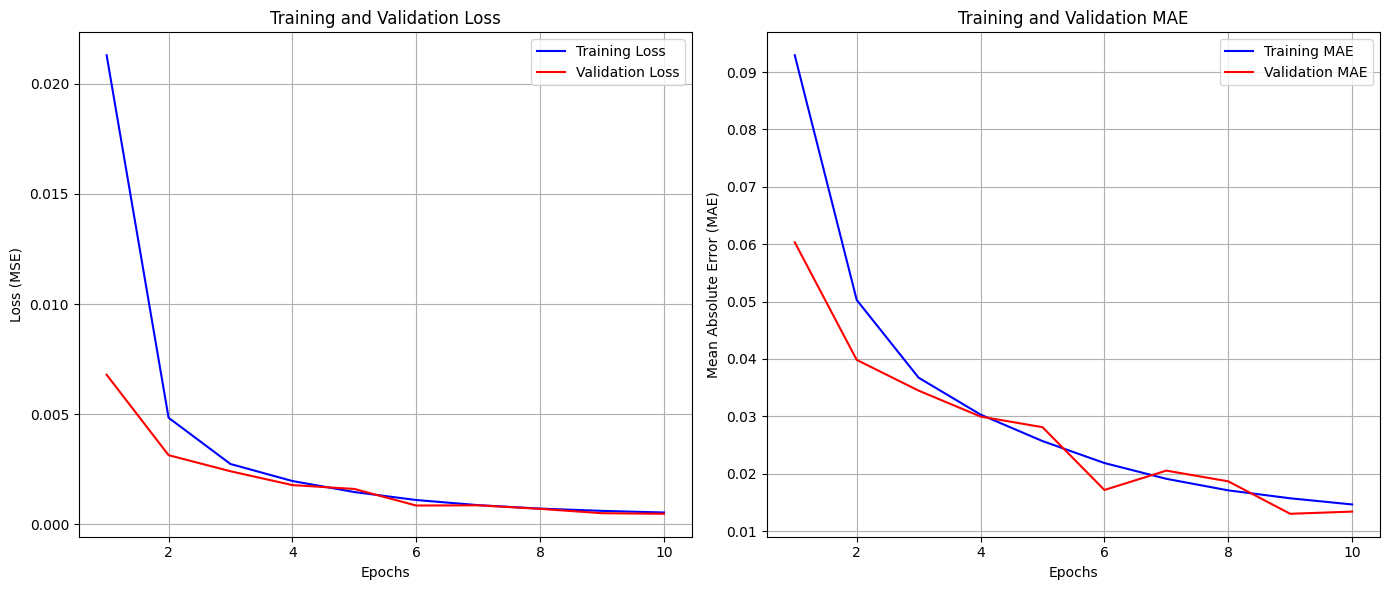

In [17]:
plot_training_history(history_scaled)

In [18]:
# Create predictions for the validation set
val_predicted = model_basic_scaled.predict(X_val)

# Convert predictions to a DataFrame for easier handling
val_predicted_scaled_df = pd.DataFrame(val_predicted, columns=['n', 'k'])

# Rescale each output
val_predicted_scaled_df['n'] = scaler_n.inverse_transform(val_predicted_scaled_df[['n']])
val_predicted_scaled_df['k'] = scaler_k.inverse_transform(val_predicted_scaled_df[['k']])

# Reshape the data: predicted data has 4 sets, each with 64 points
n_pred_data = val_predicted_scaled_df['n'].values.reshape(4, 64)  # Reshape to 4 sets of 64 points each
k_pred_data = val_predicted_scaled_df['k'].values.reshape(4, 64)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


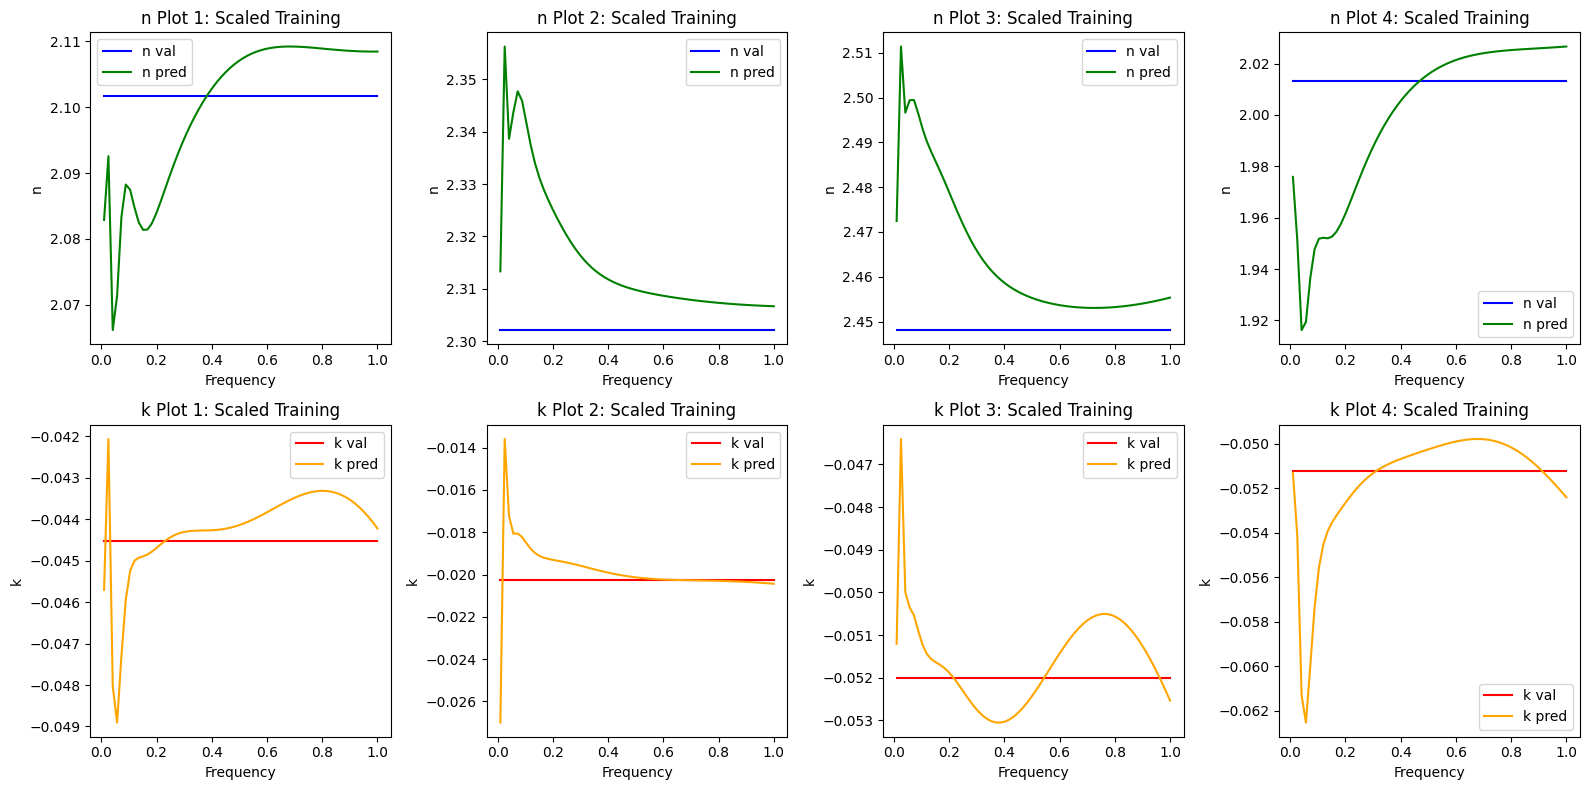

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 wide, 2 tall grid

# Plotting the n-related data
for i in range(4):  
    ax = axes[0, i]  
    ax.plot(freqs[i], n_data[i], 'b-', label='n val') 
    ax.plot(freqs[i], n_pred_data[i], 'g-', label='n pred')  
    ax.set_title(f'n Plot {i + 1}: Scaled Training')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('n')
    ax.legend()

# Plotting the k-related data
for i in range(4):  
    ax = axes[1, i]  
    ax.plot(freqs[i], k_data[i], 'r-', label='k val')  
    ax.plot(freqs[i], k_pred_data[i], 'orange', label='k pred')  
    ax.set_title(f'k Plot {i + 1}: Scaled Training')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('k')
    ax.legend()


plt.tight_layout()

plt.show()

## Add noise to signals to see if it improves fitting

In [20]:
# Define the standard deviation of the Gaussian noise
std_dev_H = 0.01  
std_dev_phi = 1 

# Add Gaussian noise to each column
X_noisy = X.copy()
X_noisy['H'] += np.random.normal(0, std_dev_H, size=X['H'].shape)
X_noisy['phi'] += np.random.normal(0, std_dev_phi, size=X['phi'].shape)

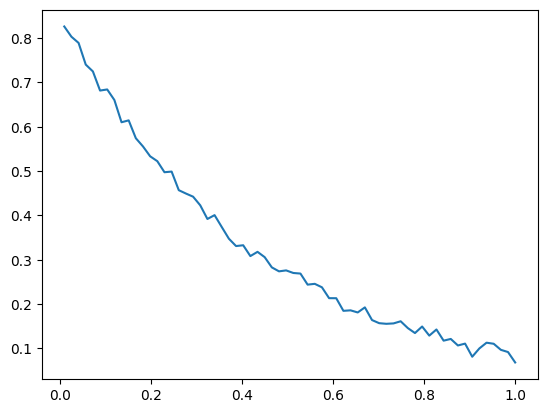

In [21]:
plt.plot(X_noisy['freq'].head(64), X_noisy['H'].head(64))

In [22]:
X_train_noisy, X_test_noisy, Y_train_noisy, Y_test_noisy = train_test_split(X_noisy, Y, test_size=0.3, random_state=42)

In [23]:
display(X_train_noisy.head())
display(Y_train_noisy.head())

,H,phi,freq
832425,0.718637,-61.134287,0.654286
512135,0.686430,-7.340922,0.120000
81354,0.465089,-13.082016,0.167143
76756,0.318807,-30.054151,0.324286
84520,0.064930,-47.244329,0.638571


,n,k
832425,2.72809,-0.001989
512135,2.00301,-0.035894
81354,2.46171,-0.066431
76756,2.72966,-0.052076
84520,2.37372,-0.083242


In [24]:
# Initialize scalers for noisy X features
noisy_scaler_n = MinMaxScaler(feature_range=(0, 1))
noisy_scaler_k = MinMaxScaler(feature_range=(0, 1))

# Normalize outputs
Y_train_scaled_noisy = Y_train_noisy.copy()
Y_test_scaled_noisy = Y_test_noisy.copy()

# Scale the columns explicitly
Y_train_scaled_noisy['n'] = noisy_scaler_n.fit_transform(Y_train_noisy[['n']])
Y_train_scaled_noisy['k'] = noisy_scaler_k.fit_transform(Y_train_noisy[['k']])
Y_test_scaled_noisy['n'] = noisy_scaler_n.transform(Y_test_noisy[['n']])
Y_test_scaled_noisy['k'] = noisy_scaler_k.transform(Y_test_noisy[['k']])

# Build the model for scaled data
model_basic_noisy_scaled = build_model_basic(input_shape, output_shape)

# Compile the model
model_basic_noisy_scaled.compile(optimizer='adam', 
                    loss='mse',  # Mean Squared Error for regression
                    metrics=['mae'])  # Mean Absolute Error as an additional metric

# Summary
model_basic_noisy_scaled.summary()

# Train the model on scaled outputs
history_noisy_scaled = model_basic_noisy_scaled.fit(
    X_train_noisy, Y_train_scaled_noisy,
    validation_data=(X_test_noisy, Y_test_scaled_noisy),
    epochs=10,
    batch_size=256,
    verbose=1
)

Model: "model_basic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,538 (6.01 KB)

 Trainable params: 1,538 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0412 - mae: 0.1400 - val_loss: 0.0105 - val_mae: 0.0769
Epoch 2/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0100 - mae: 0.0742 - val_loss: 0.0076 - val_mae: 0.0618
Epoch 3/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0074 - mae: 0.0603 - val_loss: 0.0067 - val_mae: 0.0554
Epoch 4/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0067 - mae: 0.0561 - val_loss: 0.0063 - val_mae: 0.0532
Epoch 5/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0062 - mae: 0.0528 - val_loss: 0.0058 - val_mae: 0.0492
Epoch 6/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0059 - mae: 0.0501 - val_loss: 0.0059 - val_mae: 0.0505
Epoch 7/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0057 - mae: 0.0483 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 8/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0056 - mae: 0.0470 - val_loss: 0.0054 - val_mae: 0.0456
Epoch 9/10
3500/3500 ━━━━━━━━━━━

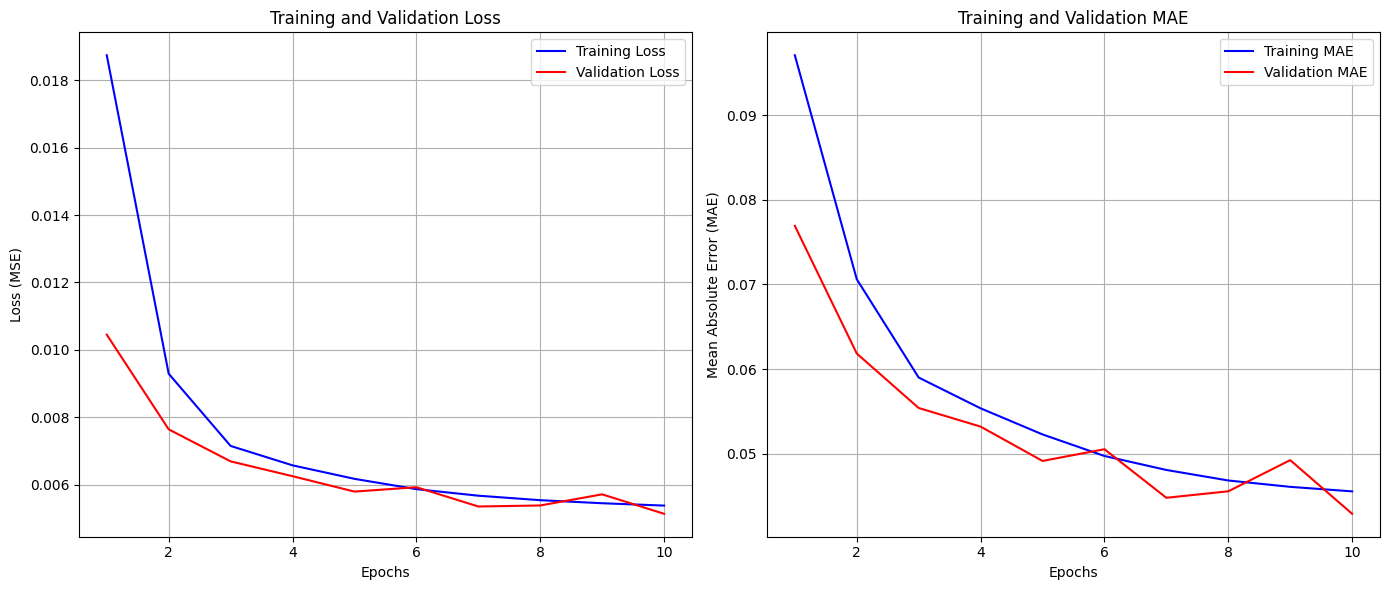

In [25]:
plot_training_history(history_noisy_scaled)

In [26]:
noisy_predictions = model_basic_noisy_scaled.predict(X_val)

noisy_predictions_df = pd.DataFrame(noisy_predictions, columns=['n_scaled', 'k_scaled'])

# Rescale each output
noisy_predictions_df['n'] = noisy_scaler_n.inverse_transform(noisy_predictions_df[['n_scaled']])
noisy_predictions_df['k'] = noisy_scaler_k.inverse_transform(noisy_predictions_df[['k_scaled']])

# Reshape the data: predicted data has 4 sets, each with 64 points
n_pred_data_noisy = noisy_predictions_df['n'].values.reshape(4, 64)  # Reshape to 4 sets of 64 points each
k_pred_data_noisy = noisy_predictions_df['k'].values.reshape(4, 64)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


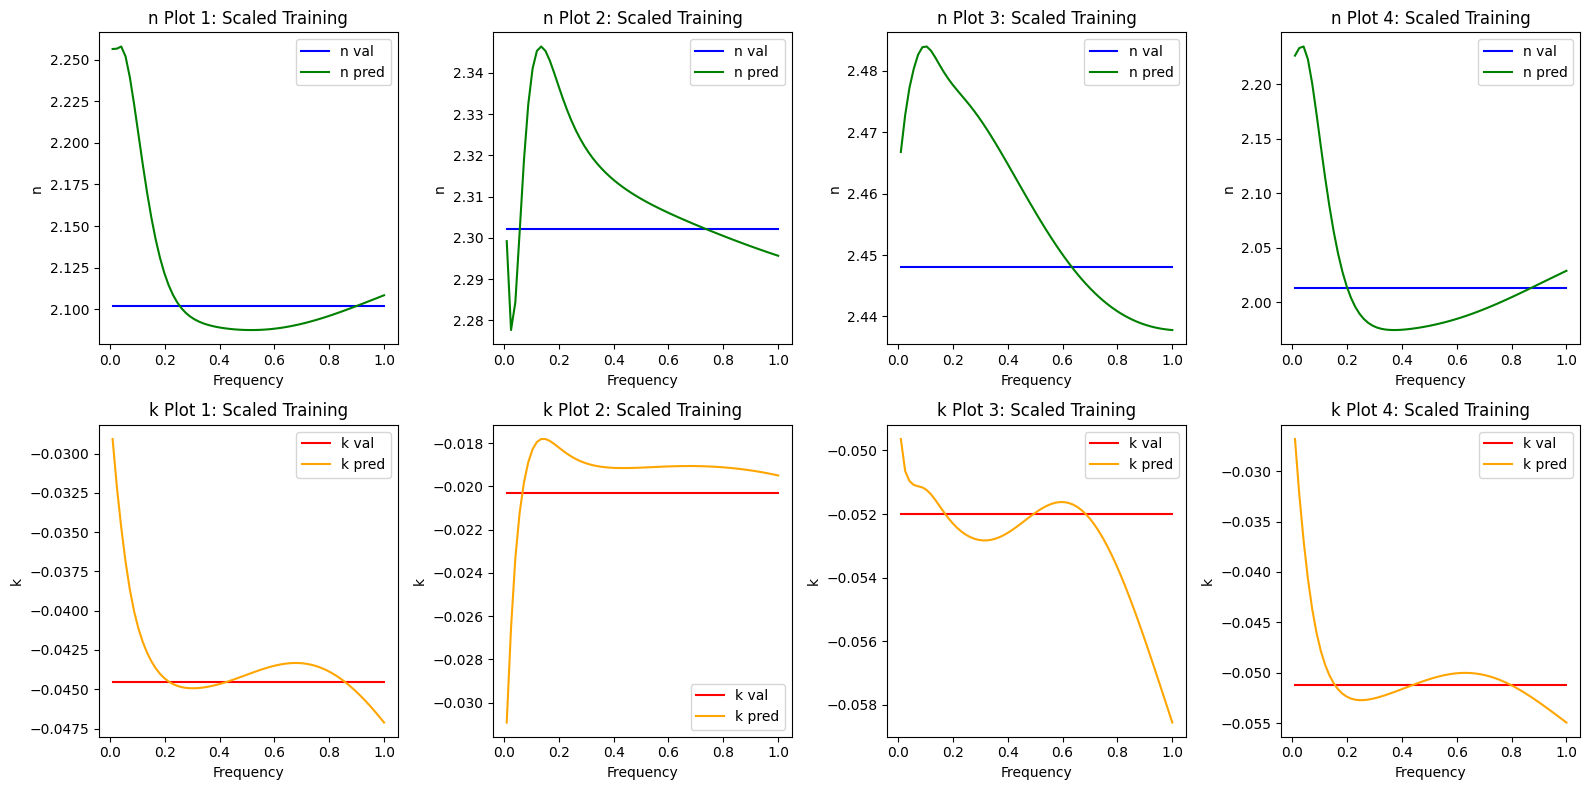

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 4 wide, 2 tall grid

# Plotting the n-related data
for i in range(4):  
    ax = axes[0, i]  
    ax.plot(freqs[i], n_data[i], 'b-', label='n val') 
    ax.plot(freqs[i], n_pred_data_noisy[i], 'g-', label='n pred')  
    ax.set_title(f'n Plot {i + 1}: Scaled Training')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('n')
    ax.legend()

# Plotting the k-related data
for i in range(4):  
    ax = axes[1, i]  
    ax.plot(freqs[i], k_data[i], 'r-', label='k val')  
    ax.plot(freqs[i], k_pred_data_noisy[i], 'orange', label='k pred')  
    ax.set_title(f'k Plot {i + 1}: Scaled Training')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('k')
    ax.legend()


plt.tight_layout()

plt.show()